<a href="https://colab.research.google.com/github/leejunho12316/P-Project-Machine-Learning/blob/main/processPattern_%EB%B6%84%EB%A5%98_%EB%8B%A4%EC%A4%91_%ED%81%B4%EB%9E%98%EC%8A%A4_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 시작
패키지 install, 함수 정의

https://wikidocs.net/192931


In [1]:
pip install jpype1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 7.1 MB/s eta 0:00:00


In [2]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 43.6 MB/s eta 0:00:00


In [3]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00


In [5]:
#한글파일 unzip시 깨짐 encoding decoding으로 방지하는 함수, num개만 압축해제
def unzip(source_path, dest_path):
  with zipfile.ZipFile(source_path, 'r') as zf:
    zipInfo = zf.infolist()
    for member in zipInfo:
      try:
        #print(member.filename.encode('cp437').decode('euc-kr','ignore'))
        member.filename = member.filename.encode('cp437').decode('euc-kr','ignore')
        zf.extract(member,dest_path)
      except:
        print(source_path)
        raise Exception('??')

## 데이터 준비
데이터 다운로드

In [1]:
from google.colab import drive
import shutil
import zipfile
import os

import json

In [2]:
drive.mount('/content/drive')

source_path = '/content/drive/MyDrive/ML_Data/146.낚시성 기사 탐지 데이터.zip'
destination_path = '/content/146.낚시성 기사 탐지 데이터.zip'
shutil.copyfile(source_path,destination_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/146.낚시성 기사 탐지 데이터.zip'

## Data 다운로드/압축해제
원문 Clickbait Direct 만 뽑아 새로운 데이터셋 생성 - 본문/제목 다중입력

In [3]:
#데이터 저장을 위한 경로 만들기
root_path = '/content/root'
training_data_path = os.path.join(root_path,'Training')
test_data_path = os.path.join(root_path,'Test')

p = [root_path,training_data_path,test_data_path]
for i in p:
  if not os.path.exists(i):
    os.mkdir(i)

In [6]:
#전체 중 Clickbait_Direct 아닌거 삭제 - Clickbait_Direct 만 processPattern 가짐
unzip('/content/146.낚시성 기사 탐지 데이터.zip','/content')
raw_data_path = '/content/146.낚시성 기사 탐지 데이터'

for root,dirs,files in os.walk(raw_data_path):
  for fn in files:
    if 'Clickbait_Direct' not in fn:
      os.remove(root+'/'+fn)



In [7]:
#(임시) zip 하나만 풀어서 dataset 만들기
a='/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part1_Clickbait_Direct_EC.zip'
b='/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part1_Clickbait_Direct_IS.zip'
unzip(a,training_data_path)
unzip(b,test_data_path)

## 데이터 전처리

본문->토큰화->벡터화(원-핫 인코딩)

1.   train_data
[본문.........],[본문..........]....
2.   token_train_data
[시퀀스시퀀스시퀀스],[시퀀스시퀀스시퀀스],[시퀀스시퀀스시퀀스]....
3. x_train
[0,0,0,0,1,0,0,,,,],[0,1,0,0,0,0,,,,,,],,,,,



데이터준비

In [8]:
import re
import numpy as np

#training_data 경로의 모든 파일 읽어오기 (json)
training_files = []
for root, dirs, files in os.walk(training_data_path):
  for fn in files:
    training_files.append(root+'/'+fn)


#각 json 파일의 본문을 리스트에 추가
train_data_title = []#np.array([])
train_data = []#np.array([])
train_labels = []

for i in training_files:
  with open(i,'r',encoding='utf-8') as file:
    data = json.load(file)

    #제목
    newsTitle = data.get('sourceDataInfo').get('newsTitle')
    newsTitle = re.sub('[()]',' ',newsTitle)
    newsTitle = re.sub(r'\\',' ',newsTitle)
    train_data_title.append(newsTitle) #train_data_title = np.append(newsTitle, train_data_title)
    #본문
    newsContent = data.get('sourceDataInfo').get('newsContent')
    #newsContent = re.sub(r'\n',' ', newsContent) # 엔터키를 없애버리면 sentencepiece 패키지가 멍청해서 인식을 못함
    newsContent = re.sub('[()]',' ',newsContent)
    newsContent = re.sub(r'\\',' ',newsContent)
    train_data.append(newsContent) #train_data = np.append(newsContent,train_data)
    #라벨
    train_labels.append(int(data.get('sourceDataInfo').get('processPattern')))

#-------------------------------------------------------------------------
#위에랑 똑같은거 test에도
test_files = []
for root,dirs,files in os.walk(test_data_path):
  for fn in files:
    test_files.append(root+'/'+fn)

test_data = []#np.array([])
test_data_title = []#np.array([])
test_labels = []

for i in test_files:
  with open(i,'r',encoding = 'utf-8') as file:
    data = json.load(file)

    #제목
    newsTitle = data.get('sourceDataInfo').get('newsTitle')
    newsTitle = re.sub('[()]',' ',newsTitle)
    newsTitle = re.sub(r'\\',' ',newsTitle)
    test_data_title.append(newsTitle) #test_data_title = np.append(newsTitle, test_data_title)

    newsContent = data.get('sourceDataInfo').get('newsContent')
    newsContent = re.sub('[()]',' ',newsContent)
    newsContent = re.sub(r'\\',' ',newsContent)
    test_data.append(newsContent) #test_data = np.append(newsContent,test_data)

    test_labels.append(int(data.get('sourceDataInfo').get('processPattern')))

본문 - 토큰화

In [9]:
#한국어 토큰화 위한 과정
#https://velog.io/@lighthouse97/%ED%85%8D%EC%8A%A4%ED%8A%B8-%EC%A0%84%EC%B2%98%EB%A6%AC-%ED%86%A0%ED%81%B0%ED%99%94

#토큰화 - 1 형태소 분석
from konlpy.tag import Okt

okt = Okt()
text = '아이고 배고파 ㅠㅠ 이럴수가. 컵라면을 사먹어요'

morphs = okt.morphs(text)
ps = okt.pos(text)
noun = okt.nouns(text)
print(f"형태소 분석 : {morphs}")
print(f'품사 태깅 : {ps}')
print(f'명사 추출 : {noun}')

형태소 분석 : ['아이고', '배고파', 'ㅠㅠ', '이럴수가', '.', '컵라면', '을', '사먹어요']
품사 태깅 : [('아이고', 'Exclamation'), ('배고파', 'Adjective'), ('ㅠㅠ', 'KoreanParticle'), ('이럴수가', 'Adjective'), ('.', 'Punctuation'), ('컵라면', 'Noun'), ('을', 'Josa'), ('사먹어요', 'Verb')]
명사 추출 : ['컵라면']


In [10]:
#토큰화 - 2 Subword Tokenizer
#BPE 알고리즘을 구현한 구글의 Sentencepiece를 사용해 내부 단어 분리 진행

#이름.model 이 sentencepiece에서 사용되는 단어집합
#이름.vocal 이 단어 집합을 텍스트 파일로 저장한것
#모든 텍스트파일을 하나의 txt에 쳐넣고 학습해 model을 만들고 각각의 train_data 안에 있는 데이터에 sp.encode를 해주면 된다.

import sentencepiece as spm
#모든 텍스트 하나의 txt에 쳐넣어 sentencepiece 학습시키기
with open('/content/test1.txt','w',encoding='utf-8') as f:
  for i in range(0,len(train_data)):
    f.write(train_data[i])
  for i in range(0,len(test_data)):
    f.write(test_data[i])

spm.SentencePieceTrainer.Train('--input=test1.txt --model_prefix=mine --vocab_size=30000 --model_type=bpe --max_sentence_length=9999')

#Sentence piece 객체 생성
sp = spm.SentencePieceProcessor()



In [11]:
#모델 불러와 인코딩, 디코딩 시험
sp.load('mine.model')
print(sp.encode(train_data[0], out_type=int))
print(sp.DecodeIds([13702, 353, 7004, 394, 497, 930, 18833, 2368, 364, 2985, 1484, 1977, 19050, 1742, 167, 3834, 5689, 18747, 1587, 105, 18992, 19310, 19131, 18907, 1880]))


[9081, 4193, 554, 698, 1380, 21899, 7882, 28749, 14857, 20, 28747, 9081, 2977, 741, 28792, 3270, 9009, 293, 28823, 2457, 13895, 1030, 28805, 74, 29689, 4151, 2938, 10374, 28747, 254, 5324, 328, 11436, 11603, 9526, 3997, 149, 770, 4458, 5284, 2457, 13895, 3792, 11, 78, 672, 16388, 11941, 209, 10082, 28747, 1030, 22532, 1190, 990, 6457, 2482, 3857, 27436, 1190, 5547, 9113, 20073, 16015, 1641, 4849, 28747, 605, 347, 17380, 1190, 24024, 7094, 267, 2739, 4215, 1535, 672, 16388, 63, 16310, 17584, 11, 20, 28747, 9081, 494, 176, 1135, 12, 28792, 3110, 9096, 8890, 3852, 14261, 28810, 10330, 248, 1030, 2843, 116, 3857, 6746, 1693, 28820, 11, 611, 2195, 2552, 21688, 28755, 26658, 10541, 12, 556, 175, 28747]
와이즈 이후 대전에서 가장 큰 국제 지양사인 세계지방정부연합 협의체를회가 10월에 열린다다리 사진 출 긴급재난 접어든현지 부처가 지원한다


In [12]:
#train_data, test_data 전부 Tokenize
token_train_data = []
for i in range(0,len(train_data)):
  token_train_data.append(sp.encode(train_data[i], out_type = int))
token_test_data = []
for i in range(0,len(test_data))  :
  token_test_data.append(sp.encode(test_data[i],out_type=int))

#train_data_title, test_data_title 전부 Tokenize
token_train_data_title = []
for i in range(0,len(train_data_title)):
  token_train_data_title.append(sp.encode(train_data_title[i], out_type=int))
token_test_data_title = []
for i in range(0,len(test_data_title)):
  token_test_data_title.append(sp.encode(test_data_title[i], out_type=int))

본문 - 벡터변환 (원-핫 인코딩)

In [13]:
#데이터 벡터변환 (원-핫 인코딩 방식 벡터변환으로 각 기사에 어떤 단어가 사용되었는지에 대한 정보를 담고 있다.)
import numpy as np

#행 : 각 기사들, 열 : 단어 시퀀스, 값 : 기사의 해당 단어 사용 여부
def vectorize_squences(sequences, dimension=30000): #dimension은 sentencepiece의 vocab_size 와 같게
  results = np.zeros((len(sequences),dimension))
  print(results.shape)

  #i번째 원소의 기사 sequence를 np.zero 각각의 줄에 그냥 다 넣기
  for i, sequence in enumerate(sequences):
    results[i,sequence] = 1
  return results

x_train = vectorize_squences(token_train_data)
x_test = vectorize_squences(token_test_data)
x_train_title = vectorize_squences(token_train_data_title)
x_test_title = vectorize_squences(token_test_data_title)

(7007, 30000)
(5502, 30000)
(7007, 30000)
(5502, 30000)


라벨->벡터변환(원 핫 인코딩)


1.   train_labels
[3,4,3,6,1,2,6,3,7,3....]
2.   one_hot_train_labels
[0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,1],[1,0,0,0,0,0,0,0]


라벨 값
*   0-5은 processPattern 11-16
*   6-9은 processPattern 21-24


In [14]:
#라벨 원-핫 인코딩 벡터변환
def to_one_hot(labels, dimension=10):
  results = np.zeros((len(labels),dimension))
  for i, label in enumerate(labels):
    if label <= 16:
      results[i,label-11] = 1
    elif label >=21:
      results[i,label-15] = 1
    else:
      pass
  return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [15]:
print(one_hot_train_labels)
print(one_hot_test_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## 3.모델 만들기


입력 Layer 2개- 본문/제목
은닉 Layer
출력 Layer 10개


In [16]:
#데이터 1:9 train:validation
num1 = len(x_train)//10*3
num2 = len(x_train_title)//10*3
num3 = len(one_hot_train_labels)//10*3

x_val = x_train[:num1]
partial_x_train = x_train[num1:]

x_val_title = x_train_title[:num2]
partial_x_train_title = x_train[num2:]

y_val = one_hot_train_labels[:num3]
partial_y_train = one_hot_train_labels[num3:]


In [17]:
print(num1, num2, num3)

2100 2100 2100


## 4. 모델 구성
출력 클래스 개수 10개

In [18]:
#######################################################################다중입력 모델 만들어보기
import keras
import tensorflow
from keras import models
from keras import layers
from keras.preprocessing.sequence import pad_sequences



#본문, 타이틀 input
title_input = keras.Input(shape=(30000,), name = 'title') #shape=(5000,) 은 1차원 배열 5000개를 받는다는 뜻
content_input = keras.Input(shape=(30000,), name = 'content')

x1 = layers.Dense(64, activation='relu')(title_input)
x1 = layers.Dropout(0.5)(x1) #과적합 방지
x1 = layers.Dense(64, activation='relu')(x1)

x2 = layers.Dense(64, activation='relu')(content_input)
x2 = layers.Dropout(0.5)(x2)
x2 = layers.Dense(64, activation='relu')(x2)

concatenated = keras.layers.concatenate([x1,x2])
concatenated = layers.Dropout(0.1)(concatenated)

output = layers.Dense(10, activation = 'softmax')(concatenated)

model = models.Model(inputs = [title_input, content_input], outputs = output)

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

training accuracy 증가 & validation accuracy 감소 : 과대적합
training data라는 악기에만 적응하고 validation이라는 새로운 악기는 연주하지 못하게 되는 현상


1.   batch size 증가
2.   항목 추가



In [19]:
history = model.fit([partial_x_train_title, partial_x_train],
                    partial_y_train, #모델이 예측해야 하는 타켓 클래스로, 마지막 Dense Layer의 출력층과 연결되어 있음
                    epochs=50,
                    batch_size=200,
                    validation_data=([x_val_title,x_val], y_val) )

Epoch 1/50
25/25 [==============================] - 13s 174ms/step - loss: 1.7392 - accuracy: 0.3621 - val_loss: 1.7441 - val_accuracy: 0.2810
Epoch 2/50
25/25 [==============================] - 1s 40ms/step - loss: 1.4735 - accuracy: 0.4455 - val_loss: 1.6786 - val_accuracy: 0.3705
Epoch 3/50
25/25 [==============================] - 1s 48ms/step - loss: 1.2473 - accuracy: 0.5262 - val_loss: 1.6655 - val_accuracy: 0.3414
Epoch 4/50
25/25 [==============================] - 1s 39ms/step - loss: 0.9351 - accuracy: 0.6862 - val_loss: 1.6794 - val_accuracy: 0.3157
Epoch 5/50
25/25 [==============================] - 1s 40ms/step - loss: 0.6432 - accuracy: 0.8078 - val_loss: 1.7074 - val_accuracy: 0.3510
Epoch 6/50
25/25 [==============================] - 1s 61ms/step - loss: 0.3995 - accuracy: 0.8961 - val_loss: 1.8636 - val_accuracy: 0.2786
Epoch 7/50
25/25 [==============================] - 1s 52ms/step - loss: 0.2402 - accuracy: 0.9456 - val_loss: 1.9309 - val_accuracy: 0.3276
Epoch 8/50


모델 구조

In [ ]:
model.summary()

성능 그래프

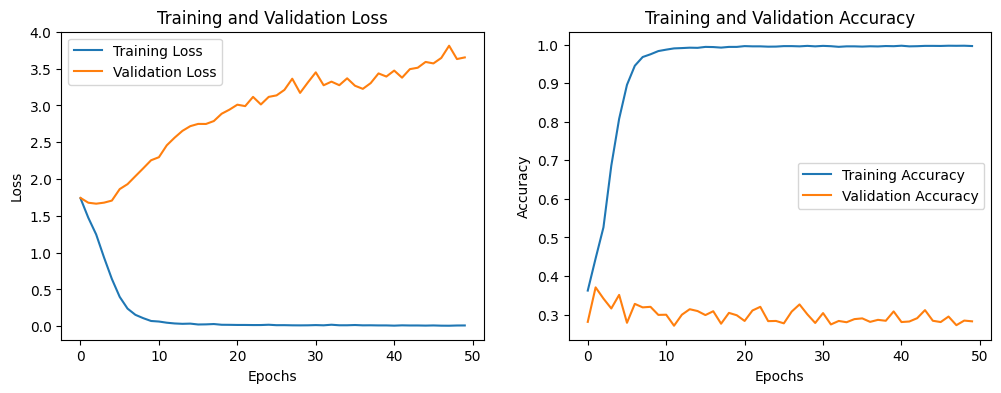

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 모델 시연

새로운 데이터로 테스트해보기
본문->토큰화->벡터화->모델 분석 ->argmax 함수

In [21]:
title = '''다니엘 헤니, 14세 연하 아내♥에 진한 키스…거침없는 애정표현" '''

text = '''[스포츠조선닷컴 이게은기자] 배우 다니엘 헤니와 그의 아내 배우 루 쿠마가이가 달달한 케미를 뽐냈다.


9일 루 쿠마가이는 다니엘 헤니와 함께 찍은 사진을 공개했다.

사진 속 루 쿠마가이는 다니엘 헤니에게 꼬옥 안긴 채 애정을 드러냈고 두 사람은 입맞춤으로 더욱 행복해 보이는 투샷을 만들었다.

맑은 하늘, 바다와 어우러져 마치 화보 같은 분위기를 풍겼다. 달달한 분위기가 보는 이들에게 부러움을 안겼다.

한편 다니엘 헤니는 지난 10월 결혼 소식을 전했다. 당시 소속사는 "(열애설) 당시 친구였던 두 사람은 이 일을 계기로 서서히 연인으로 발전했으며, 최근 양가 가족분들을 모시고 조용히 식을 올렸다. 사전에 소식을 전하지 못한 점 너른 양해 부탁드린다"라고 밝혔다.

루 쿠마가이는 다니엘 헤니보다 14세 연하로 미국에서 활동하고 있는 아시안계 배우이며 '9-1-1', '온리 더 브레이브', '굿 트러블', '라이언 핸슨 솔브스 크라임 온 텔레비전' 등에 출연했다.'''


#토큰화->패딩->벡터화->입력
token_title = sp.encode(title,out_type= int)
token_text = sp.encode(text,out_type=int)


padded_title = pad_sequences([token_title], maxlen=500) #pad_sequences 는 리스트를 받기 때문에 []해줌
padded_text = pad_sequences([token_text], maxlen=500)

vec_title = vectorize_squences(padded_title)
vec_text = vectorize_squences(padded_text)

pred1 = model.predict([vec_title,vec_text])

np.argmax(pred1[0])

(1, 30000)
(1, 30000)
1/1 [==============================] - 0s 105ms/step


3

from keras import models
from keras import layers

#Sequential 모델 정의
model = models.Sequential()
#입력층 - 64개의 뉴런, relu 활성화 함수, 10000개의 입력데이터
model.add(layers.Dense(64, activation='relu',input_shape=(5000,)))
#은닉층
model.add(layers.Dense(64, activation='relu'))
#출력층
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])